In [139]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [140]:
def get_cols_to_drop(reframed):
    lst = []

    total_length = len(reframed.columns)

    var_idx = list(reframed.columns).index('var1(t)')

    reframed.columns[num]

    for i in range(var_idx, total_length):
        if i%8 != 0:
            lst.append(reframed.columns[i])
            
    return lst

In [141]:
from pandas import read_csv
from datetime import datetime

# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('PRSA_data_2010.1.1-2014.12.31.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [142]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

In [143]:
target_values = values[:, 0].reshape(-1, 1)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit_transform(target_values)

array([[0.12977867],
       [0.14889336],
       [0.15995975],
       ...,
       [0.01006036],
       [0.00804829],
       [0.01207243]], dtype=float32)

In [144]:
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 2, 2)
reframed.columns

reframed.drop(get_cols_to_drop(reframed), axis=1, inplace=True)

#reframed.columns

In [145]:
get_cols_to_drop(reframed)

['var1(t+1)']

In [146]:
reframed.shape
reframed.columns

Index(['var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)',
       'var6(t-2)', 'var7(t-2)', 'var8(t-2)', 'var1(t-1)', 'var2(t-1)',
       'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)',
       'var8(t-1)', 'var1(t)', 'var1(t+1)'],
      dtype='object')

In [147]:
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 2, 2)
reframed.drop(get_cols_to_drop(reframed), axis=1, inplace=True)
# drop columns we don't want to predict
#reframed.drop(['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)','var8(t)',
       #        'var2(t+1)', 'var3(t+1)','var4(t+1)', 'var5(t+1)', 'var6(t+1)', 'var7(t+1)', 'var8(t+1)'], 
       #       axis=1, inplace=True)

#reframed = scaler.fit_transform(reframed)
#print(reframed.head())

In [148]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24


train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [149]:
reframed.columns

Index(['var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)',
       'var6(t-2)', 'var7(t-2)', 'var8(t-2)', 'var1(t-1)', 'var2(t-1)',
       'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)',
       'var8(t-1)', 'var1(t)', 'var1(t+1)'],
      dtype='object')

In [165]:
train[0]

array([0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
       0.00229001, 0.        , 0.        , 0.14889336, 0.36764708,
       0.24590163, 0.5272732 , 0.6666667 , 0.00381099, 0.        ,
       0.        , 0.15995975, 0.18209255], dtype=float32)

In [166]:
train[:, :-2][0]

array([0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
       0.00229001, 0.        , 0.        , 0.14889336, 0.36764708,
       0.24590163, 0.5272732 , 0.6666667 , 0.00381099, 0.        ,
       0.        ], dtype=float32)

In [168]:
train[:, -2:][0]

array([0.15995975, 0.18209255], dtype=float32)

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :-2], train[:, -2:]

test_X, test_y = test[:, :-2], test[:, -2:]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [124]:
reframed.values.shape

(43797, 32)

Train on 8760 samples, validate on 35037 samples
Epoch 1/50
 - 1s - loss: 0.0130 - val_loss: 0.0161
Epoch 2/50
 - 0s - loss: 0.0103 - val_loss: 0.0128
Epoch 3/50
 - 0s - loss: 0.0104 - val_loss: 0.0094
Epoch 4/50
 - 0s - loss: 0.0090 - val_loss: 0.0098
Epoch 5/50
 - 0s - loss: 0.0091 - val_loss: 0.0102
Epoch 6/50
 - 1s - loss: 0.0083 - val_loss: 0.0067
Epoch 7/50
 - 0s - loss: 0.0071 - val_loss: 0.0054
Epoch 8/50
 - 0s - loss: 0.0073 - val_loss: 0.0065
Epoch 9/50
 - 0s - loss: 0.0070 - val_loss: 0.0095
Epoch 10/50
 - 0s - loss: 0.0069 - val_loss: 0.0071
Epoch 11/50
 - 0s - loss: 0.0071 - val_loss: 0.0086
Epoch 12/50
 - 0s - loss: 0.0068 - val_loss: 0.0059
Epoch 13/50
 - 0s - loss: 0.0068 - val_loss: 0.0054
Epoch 14/50
 - 0s - loss: 0.0070 - val_loss: 0.0086
Epoch 15/50
 - 0s - loss: 0.0050 - val_loss: 0.0091
Epoch 16/50
 - 0s - loss: 0.0059 - val_loss: 0.0071
Epoch 17/50
 - 0s - loss: 0.0059 - val_loss: 0.0060
Epoch 18/50
 - 0s - loss: 0.0053 - val_loss: 0.0080
Epoch 19/50
 - 0s - loss

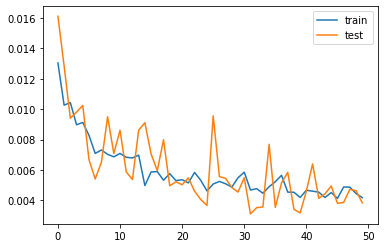

In [87]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [88]:
# make a prediction
yhat = model.predict(test_X)

inv_yhat = target_scaler.inverse_transform(yhat)
inv_y = target_scaler.inverse_transform(test_y.reshape(-1, 1))

In [91]:
#yhat.shape
test_X.shape

(35037, 1, 31)

In [28]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.979


In [36]:
#TODO
#One-hot encoding wind direction.
#Making all series stationary with differencing and seasonal adjustment.
#Providing more than 1 hour of input time steps

No                   int64
pm2.5              float64
DEWP                 int64
TEMP               float64
PRES               float64
cbwd                object
Iws                float64
Is                   int64
Ir                   int64
datetime    datetime64[ns]
dtype: object